CREDIT: https://pythonprogramming.net/custom-environment-reinforcement-learning-stable-baselines-3-tutorial/?completed=/saving-and-loading-reinforcement-learning-stable-baselines-3-tutorial/

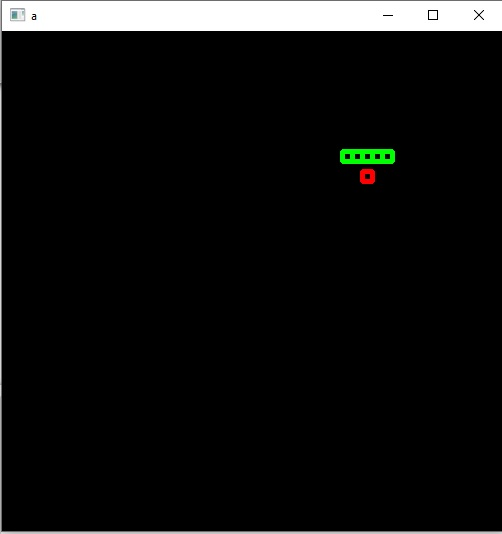

In [1]:
import gym
from gym import spaces
import numpy as np
import cv2
import random
import time
from collections import deque

# The snake game costumized enviroment

In [2]:
def collision_with_apple(apple_position):
    apple_position = [random.randrange(1,50)*10,random.randrange(1,50)*10]
    return apple_position

def collision_with_boundaries(snake_head):
    if snake_head[0]>=500 or snake_head[0]<0 or snake_head[1]>=500 or snake_head[1]<0 :
        return 1
    else:
        return 0

def collision_with_self(snake_position):
    snake_head = snake_position[0]
    if snake_head in snake_position[1:]:
        return 1
    else:
        return 0
    
class SnakeEnv(gym.Env):

    def __init__(self):
        
        super(SnakeEnv, self).__init__()
        
        self.max_snake_length = 10
        self.snake_obs = self.max_snake_length * 2
        self.snake_initial_length = 3
        
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        self.action_space = spaces.Discrete(4)
        # Example for using image as input (channel-first; channel-last also works):
        self.observation_space = spaces.Box(low=-500, high=500, shape=(5+self.snake_obs,), dtype=np.float32)
        # however long we aspire the snake to be
        self.snake_body = deque(maxlen = self.snake_obs) 
        
        
    def write_video(self):
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        self.video = cv2.VideoWriter('snake_game.mp4',fourcc,20.0,(500,500),True)
        
    def render(self, mode='human'):
        
        # Create image
        img = np.zeros((500,500,3),dtype='uint8')        
        # Display Apple
        cv2.rectangle(img,(self.apple_position[0],self.apple_position[1]),(self.apple_position[0]+10,self.apple_position[1]+10),(0,0,255),3)

        # Display Snake
        for position in self.snake_position:
            cv2.rectangle(img,(position[0],position[1]),(position[0]+10,position[1]+10),(0,255,0),3)

        # Display collision text
        if collision_with_boundaries(self.snake_head) == 1 or collision_with_self(self.snake_position) == 1:
            font = cv2.FONT_HERSHEY_SIMPLEX
            self.img = np.zeros((500,500,3),dtype='uint8')
            cv2.putText(img,'Snake length {}'.format(len(self.snake_position)),(140,250), font, 1,(255,255,255),2,cv2.LINE_AA)

        self.video.write(img)
        cv2.imshow('a',img)
        cv2.waitKey(10)
        
    def release(self):
        self.video.release()

    def step(self, action):
        
        # Change the head position based on the button direction
        if action == 1:
            self.snake_head[0] += 10
        elif action == 0:
            self.snake_head[0] -= 10
        elif action == 2:
            self.snake_head[1] += 10
        elif action == 3:
            self.snake_head[1] -= 10

        # Increase Snake length on eating apple
        apple_reward = 0.0
        if self.snake_head == self.apple_position:
            self.apple_position = collision_with_apple(self.apple_position)
            self.snake_position.insert(0,list(self.snake_head))
            apple_reward = 2.0 *(len(self.snake_position)-self.snake_initial_length)
        else:
            self.snake_position.insert(0,list(self.snake_head))
            self.snake_position.pop()
        
        # On collision kill the snake
        if collision_with_boundaries(self.snake_head) == 1 or collision_with_self(self.snake_position) == 1:
            self.done = True
            self.reward = -2.0
        else:
            euclidean_dist_to_apple = np.linalg.norm(np.array(self.snake_head) - np.array(self.apple_position))
            distance_reward = 0.0
            if self.initial_distance > 0.0:
                distance_reward =  (self.initial_distance - euclidean_dist_to_apple)/self.initial_distance
            self.total_reward = distance_reward + apple_reward
            self.reward = self.total_reward - self.prev_total_reward
            self.prev_total_reward = self.total_reward
        
        observation = self._compute_observation()
        
        return observation, self.reward, self.done, {}

    def reset(self):

        # Initial Snake and Apple position
        self.snake_position = [[250,250],[240,250],[230,250]]
        self.apple_position = [random.randrange(1,50)*10,random.randrange(1,50)*10]
        self.snake_head = [250,250]
        self.initial_distance = np.linalg.norm(np.array(self.snake_head) - np.array(self.apple_position)) 
        
        self.prev_total_reward = 0.0
        
        # empty actions
        for i in range(self.snake_obs):
            self.snake_body.append(-1) 
            
        self.done = False
        observation = self._compute_observation()
        
        return observation
        

    def _compute_observation(self):
        head_x = self.snake_head[0]
        head_y = self.snake_head[1]
        
        snake_length = len(self.snake_position)
        apple_delta_x = self.apple_position[0] - head_x
        apple_delta_y = self.apple_position[1] - head_y

        for i in range(1,len(self.snake_position)):
            self.snake_body.append(self.snake_position[i-1][0] -self.snake_position[i][0]) 
            self.snake_body.append(self.snake_position[i-1][1] -self.snake_position[i][1]) 
            

        observation = [head_x, head_y, apple_delta_x, apple_delta_y, snake_length] + list(self.snake_body) 
        observation = np.array(observation)
        
        return observation

In [3]:
env = SnakeEnv()
episodes = 5

for episode in range(episodes):
    done = False
    obs = env.reset()
    while not done:
        random_action = env.action_space.sample()
        obs, reward, done, info = env.step(random_action)
        #env.render()
        print('reward',reward)

reward -0.17444043902940698
reward -0.17744202882663856
reward -2.0
reward -2.0
reward -2.0
reward 0.060309163647676974
reward 0.060154080065027614
reward 0.01079227076115663
reward 0.060765408644041924
reward -0.011592831621084598
reward -2.0
reward -2.0


# Use a stable baselines 3 algorithm to compute the optimal policy

In [4]:
import gym
import os
from stable_baselines3 import PPO

d:\apps\python_3_8_6\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [5]:
env = SnakeEnv()

In [6]:
model_name = "PPO"
models_dir = "models/" + model_name
logdir = "logs"

In [7]:
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

## Save models at different iterations

In [8]:
env.reset()
if model_name =="PPO":
    model = PPO('MlpPolicy', env, verbose=1, tensorboard_log=logdir)
elif model_name =="A2C":
    model = A2C('MlpPolicy', env, verbose=1, tensorboard_log=logdir)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [9]:
TIMESTEPS = 10000
iters = 0
for i in range(100):
    iters += 1
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name=model_name)
    model.save(f"{models_dir}/{TIMESTEPS*iters}")

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.83     |
|    ep_rew_mean     | -2.01    |
| time/              |          |
|    fps             | 885      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 5.2          |
|    ep_rew_mean          | -2           |
| time/                   |              |
|    fps                  | 986          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0140738245 |
|    clip_fraction        | 0.228        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.37        |
|    explained_variance   | -0.254  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 22.3       |
|    ep_rew_mean          | -1.45      |
| time/                   |            |
|    fps                  | 1368       |
|    iterations           | 3          |
|    time_elapsed         | 4          |
|    total_timesteps      | 26624      |
| train/                  |            |
|    approx_kl            | 0.01173499 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.676     |
|    explained_variance   | 0.498      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0105    |
|    n_updates            | 120        |
|    policy_gradient_loss | -0.0189    |
|    value_loss           | 0.086      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 22.9        |
|    ep_rew_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 30.9       |
|    ep_rew_mean          | -1.25      |
| time/                   |            |
|    fps                  | 1294       |
|    iterations           | 4          |
|    time_elapsed         | 6          |
|    total_timesteps      | 49152      |
| train/                  |            |
|    approx_kl            | 0.01332351 |
|    clip_fraction        | 0.107      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.541     |
|    explained_variance   | 0.697      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0195    |
|    n_updates            | 230        |
|    policy_gradient_loss | -0.0185    |
|    value_loss           | 0.0476     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 30.1        |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.1        |
|    ep_rew_mean          | -1.4        |
| time/                   |             |
|    fps                  | 1226        |
|    iterations           | 5           |
|    time_elapsed         | 8           |
|    total_timesteps      | 71680       |
| train/                  |             |
|    approx_kl            | 0.017332764 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.486      |
|    explained_variance   | 0.63        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00452    |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0175     |
|    value_loss           | 0.0651      |
-----------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.4 

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.3     |
|    ep_rew_mean     | -1.14    |
| time/              |          |
|    fps             | 2206     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 94208    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 30.6        |
|    ep_rew_mean          | -1.21       |
| time/                   |             |
|    fps                  | 1449        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.019804556 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.477      |
|    explained_variance   | 0.636       |
|    lea

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 32         |
|    ep_rew_mean          | -1.17      |
| time/                   |            |
|    fps                  | 1353       |
|    iterations           | 3          |
|    time_elapsed         | 4          |
|    total_timesteps      | 118784     |
| train/                  |            |
|    approx_kl            | 0.02266728 |
|    clip_fraction        | 0.137      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.449     |
|    explained_variance   | 0.575      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0579     |
|    n_updates            | 570        |
|    policy_gradient_loss | -0.0158    |
|    value_loss           | 0.163      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 33          |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 35.4        |
|    ep_rew_mean          | -1.05       |
| time/                   |             |
|    fps                  | 1305        |
|    iterations           | 4           |
|    time_elapsed         | 6           |
|    total_timesteps      | 141312      |
| train/                  |             |
|    approx_kl            | 0.021727264 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.429      |
|    explained_variance   | 0.402       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.183       |
|    n_updates            | 680         |
|    policy_gradient_loss | -0.0127     |
|    value_loss           | 0.392       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 32.2  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 37.6        |
|    ep_rew_mean          | -1.12       |
| time/                   |             |
|    fps                  | 1281        |
|    iterations           | 5           |
|    time_elapsed         | 7           |
|    total_timesteps      | 163840      |
| train/                  |             |
|    approx_kl            | 0.025224984 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.436      |
|    explained_variance   | 0.647       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00301    |
|    n_updates            | 790         |
|    policy_gradient_loss | -0.016      |
|    value_loss           | 0.0846      |
-----------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.3 

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.6     |
|    ep_rew_mean     | -1.03    |
| time/              |          |
|    fps             | 2327     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 186368   |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 35.6       |
|    ep_rew_mean          | -1.05      |
| time/                   |            |
|    fps                  | 1575       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 188416     |
| train/                  |            |
|    approx_kl            | 0.02945103 |
|    clip_fraction        | 0.16       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.437     |
|    explained_variance   | 0.368      |
|    learning_rate     

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40.2        |
|    ep_rew_mean          | -1.24       |
| time/                   |             |
|    fps                  | 1320        |
|    iterations           | 3           |
|    time_elapsed         | 4           |
|    total_timesteps      | 210944      |
| train/                  |             |
|    approx_kl            | 0.032572664 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.388      |
|    explained_variance   | 0.201       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.197       |
|    n_updates            | 1020        |
|    policy_gradient_loss | -0.0135     |
|    value_loss           | 1.09        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 41.6  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 36.2        |
|    ep_rew_mean          | -1.14       |
| time/                   |             |
|    fps                  | 1269        |
|    iterations           | 4           |
|    time_elapsed         | 6           |
|    total_timesteps      | 233472      |
| train/                  |             |
|    approx_kl            | 0.028400425 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.373      |
|    explained_variance   | 0.298       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0684      |
|    n_updates            | 1130        |
|    policy_gradient_loss | -0.0145     |
|    value_loss           | 0.29        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 35.5  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 41.5        |
|    ep_rew_mean          | -0.953      |
| time/                   |             |
|    fps                  | 1218        |
|    iterations           | 5           |
|    time_elapsed         | 8           |
|    total_timesteps      | 256000      |
| train/                  |             |
|    approx_kl            | 0.036736604 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.344      |
|    explained_variance   | 0.0485      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00304     |
|    n_updates            | 1240        |
|    policy_gradient_loss | -0.0185     |
|    value_loss           | 0.362       |
-----------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40.5 

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.2     |
|    ep_rew_mean     | -1       |
| time/              |          |
|    fps             | 2253     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 278528   |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 41.1      |
|    ep_rew_mean          | -0.964    |
| time/                   |           |
|    fps                  | 1483      |
|    iterations           | 2         |
|    time_elapsed         | 2         |
|    total_timesteps      | 280576    |
| train/                  |           |
|    approx_kl            | 0.0344979 |
|    clip_fraction        | 0.151     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.338    |
|    explained_variance   | 0.42      |
|    learning_rate        | 0.0003    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 48.3        |
|    ep_rew_mean          | -1.15       |
| time/                   |             |
|    fps                  | 1322        |
|    iterations           | 3           |
|    time_elapsed         | 4           |
|    total_timesteps      | 303104      |
| train/                  |             |
|    approx_kl            | 0.035665322 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.351      |
|    explained_variance   | 0.383       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0676      |
|    n_updates            | 1470        |
|    policy_gradient_loss | -0.0168     |
|    value_loss           | 0.433       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 49.5    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 45.8        |
|    ep_rew_mean          | -1.01       |
| time/                   |             |
|    fps                  | 1302        |
|    iterations           | 4           |
|    time_elapsed         | 6           |
|    total_timesteps      | 325632      |
| train/                  |             |
|    approx_kl            | 0.030270118 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.339      |
|    explained_variance   | 0.354       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.28        |
|    n_updates            | 1580        |
|    policy_gradient_loss | -0.0152     |
|    value_loss           | 0.418       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 43.5  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 48.8        |
|    ep_rew_mean          | -0.839      |
| time/                   |             |
|    fps                  | 1230        |
|    iterations           | 5           |
|    time_elapsed         | 8           |
|    total_timesteps      | 348160      |
| train/                  |             |
|    approx_kl            | 0.050591588 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.327      |
|    explained_variance   | 0.242       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.139       |
|    n_updates            | 1690        |
|    policy_gradient_loss | -0.0171     |
|    value_loss           | 0.428       |
-----------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 46.9 

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 44.8     |
|    ep_rew_mean     | -0.925   |
| time/              |          |
|    fps             | 2197     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 370688   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 41.9        |
|    ep_rew_mean          | -0.975      |
| time/                   |             |
|    fps                  | 1480        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 372736      |
| train/                  |             |
|    approx_kl            | 0.036810707 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.334      |
|    explained_variance   | 0.331       |
|    lea

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 50.8       |
|    ep_rew_mean          | -1.06      |
| time/                   |            |
|    fps                  | 1369       |
|    iterations           | 3          |
|    time_elapsed         | 4          |
|    total_timesteps      | 395264     |
| train/                  |            |
|    approx_kl            | 0.04263422 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.34      |
|    explained_variance   | 0.413      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0283     |
|    n_updates            | 1920       |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 0.322      |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 52.2       |
|    ep_rew_mean

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50.5        |
|    ep_rew_mean          | -0.992      |
| time/                   |             |
|    fps                  | 1273        |
|    iterations           | 4           |
|    time_elapsed         | 6           |
|    total_timesteps      | 417792      |
| train/                  |             |
|    approx_kl            | 0.047687564 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.318      |
|    explained_variance   | 0.331       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0657      |
|    n_updates            | 2030        |
|    policy_gradient_loss | -0.0153     |
|    value_loss           | 0.287       |
-----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 54.4      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 53.8        |
|    ep_rew_mean          | -1.04       |
| time/                   |             |
|    fps                  | 1227        |
|    iterations           | 5           |
|    time_elapsed         | 8           |
|    total_timesteps      | 440320      |
| train/                  |             |
|    approx_kl            | 0.036321394 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.297      |
|    explained_variance   | 0.344       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.177       |
|    n_updates            | 2140        |
|    policy_gradient_loss | -0.0139     |
|    value_loss           | 0.394       |
-----------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48.5 

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 46.4     |
|    ep_rew_mean     | -0.953   |
| time/              |          |
|    fps             | 2291     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 462848   |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 45.6       |
|    ep_rew_mean          | -0.971     |
| time/                   |            |
|    fps                  | 1527       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 464896     |
| train/                  |            |
|    approx_kl            | 0.03590755 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.31      |
|    explained_variance   | 0.385      |
|    learning_rate     

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 51          |
|    ep_rew_mean          | -1.01       |
| time/                   |             |
|    fps                  | 1363        |
|    iterations           | 3           |
|    time_elapsed         | 4           |
|    total_timesteps      | 487424      |
| train/                  |             |
|    approx_kl            | 0.049036276 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.296      |
|    explained_variance   | 0.281       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0375      |
|    n_updates            | 2370        |
|    policy_gradient_loss | -0.0149     |
|    value_loss           | 0.303       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50.8  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50.8        |
|    ep_rew_mean          | -0.941      |
| time/                   |             |
|    fps                  | 1335        |
|    iterations           | 4           |
|    time_elapsed         | 6           |
|    total_timesteps      | 509952      |
| train/                  |             |
|    approx_kl            | 0.040378284 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.313      |
|    explained_variance   | 0.531       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0437      |
|    n_updates            | 2480        |
|    policy_gradient_loss | -0.0169     |
|    value_loss           | 0.201       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 54.1  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 46.7       |
|    ep_rew_mean          | -0.89      |
| time/                   |            |
|    fps                  | 1282       |
|    iterations           | 5          |
|    time_elapsed         | 7          |
|    total_timesteps      | 532480     |
| train/                  |            |
|    approx_kl            | 0.03456214 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.369     |
|    explained_variance   | 0.412      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.153      |
|    n_updates            | 2590       |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 0.319      |
----------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 45.8     |
|    ep_rew_mea

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 67.8     |
|    ep_rew_mean     | -0.702   |
| time/              |          |
|    fps             | 2273     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 555008   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 71.1        |
|    ep_rew_mean          | -0.612      |
| time/                   |             |
|    fps                  | 1531        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 557056      |
| train/                  |             |
|    approx_kl            | 0.038038716 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.331      |
|    explained_variance   | 0.214       |
|    lea

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 71.4       |
|    ep_rew_mean          | -0.418     |
| time/                   |            |
|    fps                  | 1391       |
|    iterations           | 3          |
|    time_elapsed         | 4          |
|    total_timesteps      | 579584     |
| train/                  |            |
|    approx_kl            | 0.03331632 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.342     |
|    explained_variance   | 0.154      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.298      |
|    n_updates            | 2820       |
|    policy_gradient_loss | -0.0177    |
|    value_loss           | 0.614      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 69.3        |
|    ep_rew_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 69.5       |
|    ep_rew_mean          | -0.814     |
| time/                   |            |
|    fps                  | 1307       |
|    iterations           | 4          |
|    time_elapsed         | 6          |
|    total_timesteps      | 602112     |
| train/                  |            |
|    approx_kl            | 0.04657747 |
|    clip_fraction        | 0.195      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.379     |
|    explained_variance   | 0.161      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.223      |
|    n_updates            | 2930       |
|    policy_gradient_loss | -0.023     |
|    value_loss           | 0.395      |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 71.3       |
|    ep_rew_mean

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 97.2        |
|    ep_rew_mean          | -0.473      |
| time/                   |             |
|    fps                  | 1287        |
|    iterations           | 5           |
|    time_elapsed         | 7           |
|    total_timesteps      | 624640      |
| train/                  |             |
|    approx_kl            | 0.023710977 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.374      |
|    explained_variance   | 0.309       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.205       |
|    n_updates            | 3040        |
|    policy_gradient_loss | -0.0175     |
|    value_loss           | 0.736       |
-----------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101  

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 84.6     |
|    ep_rew_mean     | -0.55    |
| time/              |          |
|    fps             | 2169     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 647168   |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 84.3       |
|    ep_rew_mean          | -0.495     |
| time/                   |            |
|    fps                  | 1435       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 649216     |
| train/                  |            |
|    approx_kl            | 0.05540197 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.362     |
|    explained_variance   | 0.111      |
|    learning_rate     

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 83.9      |
|    ep_rew_mean          | -0.791    |
| time/                   |           |
|    fps                  | 1269      |
|    iterations           | 3         |
|    time_elapsed         | 4         |
|    total_timesteps      | 671744    |
| train/                  |           |
|    approx_kl            | 0.0583909 |
|    clip_fraction        | 0.165     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.353    |
|    explained_variance   | 0.292     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.054     |
|    n_updates            | 3270      |
|    policy_gradient_loss | -0.0209   |
|    value_loss           | 0.278     |
---------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 82.8        |
|    ep_rew_mean          | -0.771

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 88          |
|    ep_rew_mean          | -0.596      |
| time/                   |             |
|    fps                  | 1221        |
|    iterations           | 4           |
|    time_elapsed         | 6           |
|    total_timesteps      | 694272      |
| train/                  |             |
|    approx_kl            | 0.031577587 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.315      |
|    explained_variance   | 0.254       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.148       |
|    n_updates            | 3380        |
|    policy_gradient_loss | -0.0175     |
|    value_loss           | 0.401       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 102     

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 69.9        |
|    ep_rew_mean          | -1.13       |
| time/                   |             |
|    fps                  | 1179        |
|    iterations           | 5           |
|    time_elapsed         | 8           |
|    total_timesteps      | 716800      |
| train/                  |             |
|    approx_kl            | 0.038711473 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.382      |
|    explained_variance   | 0.379       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0868      |
|    n_updates            | 3490        |
|    policy_gradient_loss | -0.0169     |
|    value_loss           | 0.199       |
-----------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 66   

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 70.5     |
|    ep_rew_mean     | -1.13    |
| time/              |          |
|    fps             | 1921     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 739328   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 77.8        |
|    ep_rew_mean          | -1.08       |
| time/                   |             |
|    fps                  | 1117        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 741376      |
| train/                  |             |
|    approx_kl            | 0.052295044 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.359      |
|    explained_variance   | 0.206       |
|    lea

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 92.3        |
|    ep_rew_mean          | -0.734      |
| time/                   |             |
|    fps                  | 1085        |
|    iterations           | 3           |
|    time_elapsed         | 5           |
|    total_timesteps      | 763904      |
| train/                  |             |
|    approx_kl            | 0.023467813 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.32       |
|    explained_variance   | 0.275       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0386      |
|    n_updates            | 3720        |
|    policy_gradient_loss | -0.0166     |
|    value_loss           | 0.346       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 94    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 94.1        |
|    ep_rew_mean          | -0.903      |
| time/                   |             |
|    fps                  | 1065        |
|    iterations           | 4           |
|    time_elapsed         | 7           |
|    total_timesteps      | 786432      |
| train/                  |             |
|    approx_kl            | 0.029222608 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.324      |
|    explained_variance   | 0.23        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.231       |
|    n_updates            | 3830        |
|    policy_gradient_loss | -0.0194     |
|    value_loss           | 0.427       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 98    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 120         |
|    ep_rew_mean          | -0.589      |
| time/                   |             |
|    fps                  | 1203        |
|    iterations           | 5           |
|    time_elapsed         | 8           |
|    total_timesteps      | 808960      |
| train/                  |             |
|    approx_kl            | 0.035492137 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.344      |
|    explained_variance   | 0.00548     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.382       |
|    n_updates            | 3940        |
|    policy_gradient_loss | 0.0107      |
|    value_loss           | 0.284       |
-----------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119  

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 108      |
|    ep_rew_mean     | -0.397   |
| time/              |          |
|    fps             | 2280     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 831488   |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 113        |
|    ep_rew_mean          | -0.506     |
| time/                   |            |
|    fps                  | 1499       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 833536     |
| train/                  |            |
|    approx_kl            | 0.03457531 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.34      |
|    explained_variance   | 0.0536     |
|    learning_rate     

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 126        |
|    ep_rew_mean          | -0.782     |
| time/                   |            |
|    fps                  | 1377       |
|    iterations           | 3          |
|    time_elapsed         | 4          |
|    total_timesteps      | 856064     |
| train/                  |            |
|    approx_kl            | 0.03573107 |
|    clip_fraction        | 0.16       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.325     |
|    explained_variance   | 0.0376     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.133      |
|    n_updates            | 4170       |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 0.43       |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 129        |
|    ep_rew_mean

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 120        |
|    ep_rew_mean          | -0.92      |
| time/                   |            |
|    fps                  | 1327       |
|    iterations           | 4          |
|    time_elapsed         | 6          |
|    total_timesteps      | 878592     |
| train/                  |            |
|    approx_kl            | 0.04058297 |
|    clip_fraction        | 0.143      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.328     |
|    explained_variance   | -0.279     |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0032    |
|    n_updates            | 4280       |
|    policy_gradient_loss | -0.0148    |
|    value_loss           | 0.0412     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 101         |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 94.2        |
|    ep_rew_mean          | -1.02       |
| time/                   |             |
|    fps                  | 1272        |
|    iterations           | 5           |
|    time_elapsed         | 8           |
|    total_timesteps      | 901120      |
| train/                  |             |
|    approx_kl            | 0.032785457 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.341      |
|    explained_variance   | 0.167       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0445      |
|    n_updates            | 4390        |
|    policy_gradient_loss | -0.0163     |
|    value_loss           | 0.337       |
-----------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 97.7 

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 135      |
|    ep_rew_mean     | -1.25    |
| time/              |          |
|    fps             | 2245     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 923648   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 154         |
|    ep_rew_mean          | -1.22       |
| time/                   |             |
|    fps                  | 1500        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.030422438 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.356      |
|    explained_variance   | 0.000723    |
|    lea

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 152         |
|    ep_rew_mean          | -0.518      |
| time/                   |             |
|    fps                  | 1231        |
|    iterations           | 3           |
|    time_elapsed         | 4           |
|    total_timesteps      | 948224      |
| train/                  |             |
|    approx_kl            | 0.031805873 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.345      |
|    explained_variance   | 0.112       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00732     |
|    n_updates            | 4620        |
|    policy_gradient_loss | -0.0221     |
|    value_loss           | 0.19        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 160   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 125        |
|    ep_rew_mean          | -1.38      |
| time/                   |            |
|    fps                  | 1212       |
|    iterations           | 4          |
|    time_elapsed         | 6          |
|    total_timesteps      | 970752     |
| train/                  |            |
|    approx_kl            | 0.02432286 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.401     |
|    explained_variance   | 0.499      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0367     |
|    n_updates            | 4730       |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 0.127      |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 130        |
|    ep_rew_mean

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 164         |
|    ep_rew_mean          | -0.8        |
| time/                   |             |
|    fps                  | 1213        |
|    iterations           | 5           |
|    time_elapsed         | 8           |
|    total_timesteps      | 993280      |
| train/                  |             |
|    approx_kl            | 0.038611658 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.348      |
|    explained_variance   | 0.176       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0449      |
|    n_updates            | 4840        |
|    policy_gradient_loss | -0.0209     |
|    value_loss           | 0.294       |
-----------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 174  

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 202      |
|    ep_rew_mean     | -1.07    |
| time/              |          |
|    fps             | 2250     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1015808  |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 208         |
|    ep_rew_mean          | -1.07       |
| time/                   |             |
|    fps                  | 1492        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 1017856     |
| train/                  |             |
|    approx_kl            | 0.029257726 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.358      |
|    explained_variance   | 0.0968      |
|    lea

In [13]:
env.reset()

model_path = f"{models_dir}/850000.zip"

if model_name =="PPO":
    model = PPO.load(model_path, env=env)
elif model_name =="A2C":
    model = A2C.load(model_path, env=env)

episodes = 10
env.write_video()
for ep in range(episodes):
    obs = env.reset()
    done = False
    while not done:
        # pass observation to model to get predicted action
        action, _states = model.predict(obs)
        # pass action to env and get info back
        obs, rewards, done, info = env.step(action)
        
        # show the environment on the screen
        env.render()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [14]:
cv2.destroyAllWindows()

In [15]:
env.release()